# FEM and kernel approximation

The kernel $K$ is the unique function in $H^s(\Omega)$ such that $\forall \phi \in H^s(\Omega)$, $$\forall x \in \Omega,\quad \lambda_n  \int_{\Omega}[K(x, \cdot)\; \phi +\sum_{i=1}^d\partial^s_{i,..., i} K(x, \cdot)\; \partial^s_{i,..., i} \phi] + \mu_n \int_{\Omega}\mathscr{D}(K(x, \cdot)) \; \mathscr{D}(\phi) = \phi(x).$$
Here, we let $\Omega = [0,1]$, $\mathscr D(f) = d/dx f - f$, $s = 1$.
This leads to
$$\lambda_n  \int_{\Omega}[K(x, \cdot)\; \phi +\frac{d}{dy}K(x, \cdot)\; \frac{d}{dy}\phi] + \mu_n \int_{\Omega}
(\frac{d}{dy} K(x, \cdot) - K(x, \cdot)) \; (\frac{d}{dy} \phi - K(x, \cdot)) = \phi(x).$$
We therefore run the FEM to compute $K(x, \cdot)$. A FEM run is required for each $X_i$ to compute the kernel matrix $(K(X_i, X_j))_{1 \leq i,j \leq n}$.

In [ ]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

In [ ]:
from matplotlib import colors

myDarkOrange = colors.to_rgb('#F47A1F')
myLightOrange = colors.to_rgb('#FDBB2F')
myDarkGreen = colors.to_rgb('#00743F')
myLightGreen = colors.to_rgb('#25B396')
myTurquoise = colors.to_rgb('#70CED0')
myLightBlue = colors.to_rgb('#1E65A7')
myDarkBlue = colors.to_rgb('#192E5B')



## Definition of the nodes and the FEM matrices

Given a discretization in $m+1$ nodes $\{0, 1/m, 2/m, ..., 1\}$, we consider the basis function $\phi_0(x) = (mx +1)1_{[-1/m, 0]}(x) + (1-mx)1_{]0, 1/m]}(x)$.

In [ ]:
def node_function(i,m,x):
  if (x>(i-1)/m) and (x < (i+1)/m):
    if x < i/m:
      return x*m-(i-1)
    else:
      return i+1-x*m
  else:
    return 0

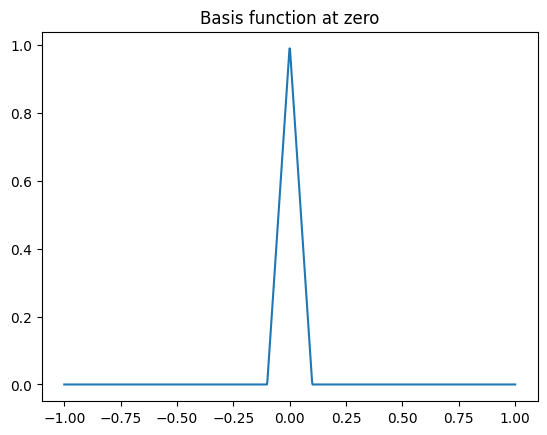

In [ ]:
m, n = 10, 1000
x_list = np.linspace(-1, 1, n)
basis_function = [node_function(0, m, x) for x in x_list]
plt.plot(x_list, basis_function)
plt.title("Basis function at zero")
plt.show()

The piecewise-linear approximation of the function $f$ which interpolate on the grid  $\{0, 1/m, 2/m, ..., 1\}$ can then be expressed using the basis function $\phi_i(x) = \phi_0(x-i/m)$ as
$$f(x) =  \sum_{i=0}^m f(i/m)\;\phi_i(x).$$
This is an approximation of $f$ in $H_1(\Omega)$, where
$$f'(x) =  \sum_{i=0}^m f(i/m)\;\phi_i'(x).$$

Thus, $\int_\Omega f \phi_j = \sum_i f(i/m) \int_\Omega \phi_i \phi_j$ and $\int_\Omega \frac{d}{dx}f \frac{d}{dx}\phi_j = \sum_i f(i/m) \int_\Omega \frac{d}{dx}\phi_i \frac{d}{dx}\phi_j$.
By denoting $f_{nodes} = (f(i/m))_{0\leq i \leq m}$ and $M_1$ the matrix of coefficients $(\int_\Omega \phi_i \phi_j)_{0\leq i,j\leq m}$, we deduce that  $(\int_\Omega f \phi_j)_{0\leq j \leq m} = M_1 f_{nodes}$. Similarly, let $M_2$ be the matrix of coefficients $(\int_\Omega \phi_i \frac{d}{dx}\phi_j)_{0\leq i,j\leq m}$ and $M_3$ be the matrix of coefficients $(\int_\Omega \frac{d}{dx}\phi_i \frac{d}{dx}\phi_j)_{0\leq i,j\leq m}$.

Evaluation the weak formulation
$$\lambda_n  \int_{\Omega}[K(x, \cdot)\; \phi +\frac{d}{dy}K(x, \cdot)\; \frac{d}{dy}\phi] + \mu_n \int_{\Omega}
(\frac{d}{dy} K(x, \cdot) - K(x, \cdot)) \; (\frac{d}{dy} \phi - K(x, \cdot)) = \phi(x)$$
at test functions $\phi = \phi_i$
leads to the linear system
$$\lambda_n (M_1+M_3)f_{nodes}+ \mu_n (M_1 -  M_2 - M_2^\top +M_3)f_{nodes} = \bar \phi,$$
where $\bar \phi = (\phi_i(x))_{0\leq i \leq m}$.
The PDE solution estimation from the FEM is then given by
$$f_{nodes} = (\lambda_n (M_1+M_3)+ \mu_n (M_1 -  M_2 - M_2^\top +M_3))^{-1}\bar \phi.$$

In [ ]:
def FEM(x_eval, m, lambda_n, mu_n):
  h = 1 / m
  # Coordinates of nodes
  x_list = np.linspace(0, 1, m+1)

  # Initialize global stiffness matrix and load vector
  K = np.zeros((m+1, m+1))
  F = np.zeros(m+1)


  for i in range(m):
      # Nodes of the current element
      node1 = i
      node2 = i + 1

      if i == 0:
        phiphi = np.array([[2, 1], [1, 4]]) * h / 6 # int_0^1 phi_i phi_j
        phidphi = np.array([[-1/2, 1/2], [-1/2, 0]]) # int_0^1 phi_i dphi_j/dx
        dphidphi = np.array([[1, -1], [-1, 2]]) / h # int_0^1 dphi_i/dx dphi_j/dx
      elif i < m-1:
        phiphi = np.array([[4, 1], [1, 4]]) * h / 6 # int_0^1 phi_i phi_j
        phidphi = np.array([[0, 1/2], [-1/2, 0]])
        dphidphi = np.array([[2, -1], [-1, 2]]) / h # int_0^1 dphi_i/dx dphi_j/dx
      else:
        phiphi = np.array([[4, 1], [1, 2]]) * h / 6 # int_0^1 phi_i phi_j
        phidphi = np.array([[0, 1/2], [-1/2, 1/2]])
        dphidphi = np.array([[2, -1], [-1, 1]]) / h # int_0^1 dphi_i/dx dphi_j/dx

      Sobolev = phiphi + dphidphi
      PDE = dphidphi - (phidphi+ np.transpose(phidphi)) + phiphi # int_0^1 (dphi_i/dx - phi_i)(dphi_j/dx - phi_j) pour l'EDP d/dx f = f

      # Adding local stiffness matrix to the global stiffness matrix
      K[node1:node2+1, node1:node2+1] = lambda_n*Sobolev + mu_n*PDE
      F[i] = node_function(i, m, x_eval)

  # Solve the linear system
  f_nodes = np.linalg.solve(K, F)
  f = [f_nodes[i]*node_function(i,m, x_list[i]) for i in range(m+1)]
  return x_list, f_nodes, f

## Solving the PDE to compute the kernel

Here we plot the function $K(0.4, \cdot)$ for $\lambda_n = 10^{-2}$ and $\mu_n = 0$.

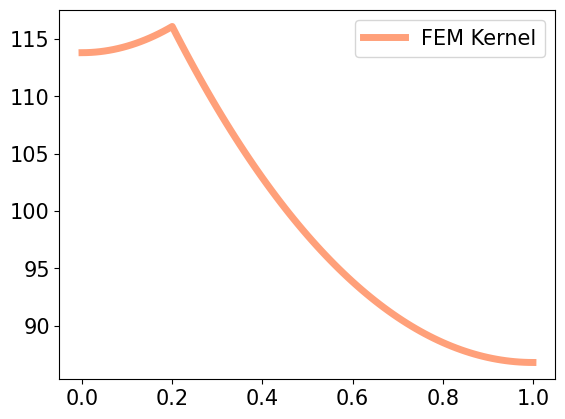

In [ ]:
# Number of elements
m = 100
x_eval = 0.2
lambda_n, mu_n = 0.01,0

x_list, f_nodes, f = FEM(x_eval, m, lambda_n, mu_n)

plt.rcParams.update({'font.size': 15})
plt.plot(x_list, f, linewidth=5, label='FEM Kernel', c='lightsalmon')
plt.xlabel('')
plt.ylabel('')
plt.legend()
#plt.grid(True)
plt.savefig("fig1.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Check in the interpolation regime

To test the method, we check that the kernel indeed interpolates in the regime $\mu_n =0$ and $\lambda_n \to 0$.

In [ ]:
def kernel_interpolation(m, lambda_n, mu_n, data_t, data_y):
  kernel_matrix = np.zeros((n, n))
  for i in range(n):
    x_eval = data_t[i]
    x_eval  = x_eval if x_eval < 1-1/m else 1-1/m
    kernel_function = FEM(x_eval, m, lambda_n, mu_n)[2]
    for j in range(n):
      index = int(m*data_t[j])
      weight1, weight2 = m*data_t[j] - index, index +1 -m*data_t[j]
      kernel_matrix[i,j]+= weight1*kernel_function[index] + weight2*kernel_function[index+1]
  f_interpolation = np.zeros(n)
  for i in range(n):
    f_interpolation[i] = kernel_matrix[i]@np.linalg.solve((kernel_matrix + n*np.eye(n)), data_y)
  return f_interpolation

In [ ]:
m = 100
data_t = np.array([0.1, 0.5, 0.8, 0.9])
n = len(data_t)
data_y = np.exp(data_t)+0.1*np.random.randn(n)

lambda_n, mu_n = 0.00001,0
f_interpolation = kernel_interpolation(m, lambda_n, mu_n, data_t, data_y)

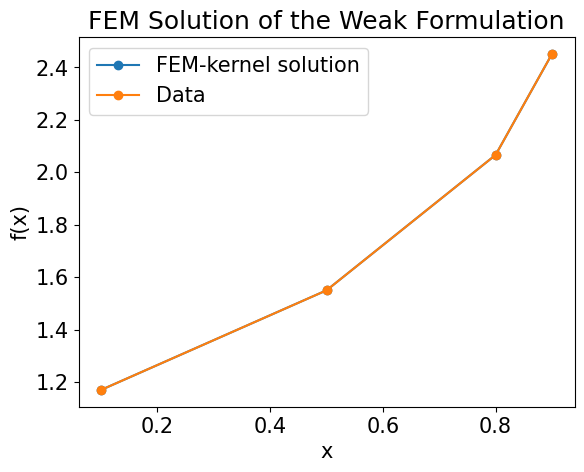

In [ ]:
plt.plot(data_t, f_interpolation, '-o', label='FEM-kernel solution')
plt.plot(data_t, data_y, '-o', label='Data')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('FEM Solution of the Weak Formulation')
plt.legend()
#plt.grid(True)
plt.show()

## Experiment with $f^\star = \exp$

In [ ]:
np.random.seed(5678)
m = 100
n=10
data_t = np.sort(np.random.rand(n))
data_y = np.exp(data_t)+0.1*np.random.randn(n)

lambda_n, mu_n = 10**-10,1000
f_interpolation = kernel_interpolation(m, lambda_n, mu_n, data_t, data_y)

<ipython-input-25-ddc5d34431f6>:2: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(data_t, data_y,  label='Data', c=myLightGreen, alpha=0.6) #'mediumpurple'


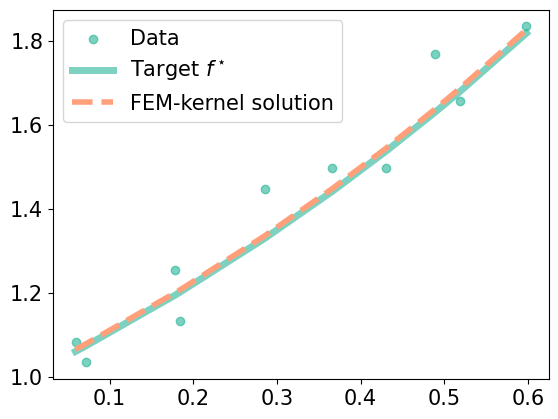

In [ ]:
plt.rcParams.update({'font.size': 15})
plt.scatter(data_t, data_y,  label='Data', c=myLightGreen, alpha=0.6) #'mediumpurple'
plt.plot(data_t, np.exp(data_t), '-', linewidth=5, c=myLightGreen, alpha = 0.6, label='Target $f^\star$')
plt.plot(data_t, f_interpolation, '--', c='lightsalmon', linewidth=4, label='FEM-kernel solution')


plt.xlabel('')
plt.ylabel('')
plt.legend()
#plt.grid(True)
plt.savefig("fig2.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
print("L2 error = "+ str(np.mean(np.square(np.exp(data_t)-np.array(f_interpolation)))))

L2 error = 4.255699464330316e-05
